<a href="https://colab.research.google.com/github/emchan4/CIND820-medical-no-show-prediction/blob/main/Code/CIND820InitialResultsandCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIND820 Capstone Project: Predicting Medical Appointment No-Shows
This notebook is part of Milestone 3: Initial Results and Code for CIND820 Capstone Project.
It demonstrates the initial results and code for predicting medical appointment no-shows using machine learning classification techniques.

## Objectives
- Load and explore the dataset
- Perform data preprocessing and feature engineering
- Train and evaluate classification models
- Compare model performance and validate results

## Notebook Structure
- Import libraries
- Load dataset
- Data summary and quality checks
- Exploratory Data Analysis (EDA)
- Preprocessing
- Model training, evaluation, and comparison

In [2]:
# Import Libraries
# This section imports all required libraries for data analysis, preprocessing, modeling, and evaluation.

# -------------------------------
# Data Manipulation and Visualization
# -------------------------------
import pandas as pd                # For data loading, cleaning, and manipulation
import matplotlib.pyplot as plt    # For creating plots and visualizations
import seaborn as sns              # For advanced statistical visualizations

# -------------------------------
# Machine Learning Models
# -------------------------------
from sklearn.linear_model import LogisticRegression        # Baseline classification model
from sklearn.tree import DecisionTreeClassifier            # Tree-based model for interpretability
from sklearn.ensemble import RandomForestClassifier        # Ensemble model for improved accuracy
from xgboost import XGBClassifier                          # Gradient boosting model for high performance

# -------------------------------
# Model Selection and Evaluation
# -------------------------------
from sklearn.model_selection import train_test_split, cross_val_score  # Train-test split and cross-validation
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)               # Performance metrics

# -------------------------------
# Preprocessing and Imbalanced Data Handling
# -------------------------------
from sklearn.impute import SimpleImputer        # For handling missing values
from sklearn.preprocessing import StandardScaler # For feature scaling
from imblearn.over_sampling import SMOTE        # For addressing class imbalance

# -------------------------------
# Utilities
# -------------------------------
from tabulate import tabulate                   # For formatted output tables

# -------------------------------
# Environment Information
# -------------------------------
import sys
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")
print(f"XGBoost version: {__import__('xgboost').__version__}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas version: 2.2.2
Scikit-learn version: 1.6.1
XGBoost version: 3.1.1


## Dataset Download and Loading
This section checks if the dataset files exist locally. If not, it downloads and extracts them from the GitHub repository. After ensuring the files are available, it loads the following CSV files into pandas DataFrames:

- `appointments.csv`: Appointment details and attendance status.
- `patients.csv`: Patient demographics.
- `slots.csv`: Time slot availability.

Finally, it previews the datasets by displaying their shape, column names, and the first few rows.

In [3]:
# Dataset Download and Loading
# This section:
# 1. Checks for dataset files locally.
# 2. Downloads and extracts them if missing.
# 3. Loads appointments, patients, and slots data into pandas DataFrames.
# 4. Prints basic information about each dataset for verification.

import os
import zipfile
import requests

# Define file names and URL
DATA_URL = "https://raw.githubusercontent.com/emchan4/CIND820-medical-no-show-prediction/main/Dataset/Medical_Appt_Scheduling_Data.zip"
ZIP_FILE = "Medical_Appt_Scheduling_Data.zip"
FILES = ["appointments.csv", "patients.csv", "slots.csv"]

def download_and_extract(url, zip_path):
    """Download and extract dataset zip file."""
    try:
        print("Downloading dataset...")
        response = requests.get(url)
        response.raise_for_status()
        with open(zip_path, "wb") as f:
            f.write(response.content)
        print("Extracting files...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall()
        print("Download and extraction completed.")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        raise

# Check if all files exist
if not all(os.path.exists(file) for file in FILES):
    download_and_extract(DATA_URL, ZIP_FILE)
else:
    print("Dataset already exists. Skipping download.")

# Load CSV files into DataFrames
try:
    appointments = pd.read_csv("appointments.csv", encoding="utf-8")
    patients = pd.read_csv("patients.csv", encoding="utf-8")
    slots = pd.read_csv("slots.csv", encoding="utf-8")
    print("\nFiles loaded successfully.")
except Exception as e:
    print(f"Error loading files: {e}")
    raise

# Preview datasets
for name, df in zip(["Appointments", "Patients", "Slots"], [appointments, patients, slots]):
    print(f"\n{name} Dataset: Shape = {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(df.head(3))

Extracting files...
Download and extraction completed.

Files loaded successfully.

Appointments Dataset: Shape = (111488, 16)
Columns: ['appointment_id', 'slot_id', 'scheduling_date', 'appointment_date', 'appointment_time', 'scheduling_interval', 'status', 'check_in_time', 'appointment_duration', 'start_time', 'end_time', 'waiting_time', 'patient_id', 'sex', 'age', 'age_group']
   appointment_id  slot_id scheduling_date appointment_date appointment_time  \
0             138        1      2014-12-28       2015-01-01         08:00:00   
1             146       23      2014-12-29       2015-01-01         13:30:00   
2              21       24      2014-12-17       2015-01-01         13:45:00   

   scheduling_interval          status check_in_time  appointment_duration  \
0                    4  did not attend           NaN                   NaN   
1                    3  did not attend           NaN                   NaN   
2                   15        attended      13:36:45           

## Dataset Summary and Quality Checks
This section provides an overview of the datasets by generating descriptive statistics and checking for missing values. It also includes:

- Shape and column names for each dataset.
- Summary statistics for numeric and categorical features.
- Missing value counts for all columns.
- Status distribution for the `appointments` dataset.

These checks help identify data quality issues and guide preprocessing steps.

In [4]:
# Dataset Summary and Quality Checks
# This section:
# 1. Prints dataset shape and column names.
# 2. Displays descriptive statistics for all columns.
# 3. Shows missing value counts.
# 4. Provides a quick categorical summary for the 'status' column if present.

from tabulate import tabulate

def summarize_dataset(name, df):
    """Print summary statistics and missing value info for a given DataFrame."""
    print(f"\n{'='*40}\n{name} Dataset Summary\n{'='*40}")

    # Shape and columns
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}\n")

    # Descriptive statistics
    print("Descriptive Statistics:")
    print(tabulate(df.describe(include='all').reset_index(), headers='keys', tablefmt='grid'))

    # Missing values
    missing = df.isnull().sum()
    print("\nMissing Values:")
    print(tabulate(missing.reset_index(), headers=['Column', 'Missing Count'], tablefmt='grid'))

    # Quick categorical summary for key columns
    if 'status' in df.columns:
        print("\nStatus Distribution:")
        print(tabulate(df['status'].value_counts().reset_index(), headers=['Status', 'Count'], tablefmt='grid'))

# Summarize all datasets
summarize_dataset("Appointments", appointments)
summarize_dataset("Patients", patients)
summarize_dataset("Slots", slots)


Appointments Dataset Summary
Shape: (111488, 16)
Columns: ['appointment_id', 'slot_id', 'scheduling_date', 'appointment_date', 'appointment_time', 'scheduling_interval', 'status', 'check_in_time', 'appointment_duration', 'start_time', 'end_time', 'waiting_time', 'patient_id', 'sex', 'age', 'age_group']

Descriptive Statistics:
+----+---------+------------------+-----------+-------------------+--------------------+--------------------+-----------------------+----------+-----------------+------------------------+--------------+------------+----------------+--------------+--------+-------------+-------------+
|    | index   |   appointment_id |   slot_id | scheduling_date   | appointment_date   | appointment_time   |   scheduling_interval | status   | check_in_time   |   appointment_duration | start_time   | end_time   |   waiting_time |   patient_id | sex    |         age | age_group   |
+====+=========+==================+===========+===================+====================+============

## Exploratory Data Analysis (EDA)
This section visualizes key patterns in the dataset to understand factors influencing appointment attendance. The following plots will be generated:

- Distribution of appointment status
- Age distribution of patients
- Scheduling interval distribution
- Attendance status by hour of appointment
- No-show rate by day of the week
- Boxplot of scheduling interval vs attendance
- Heatmap of no-show rates by hour and day of the week
- Correlation matrix for numeric features
These visualizations help identify trends and potential predictors for no-shows.

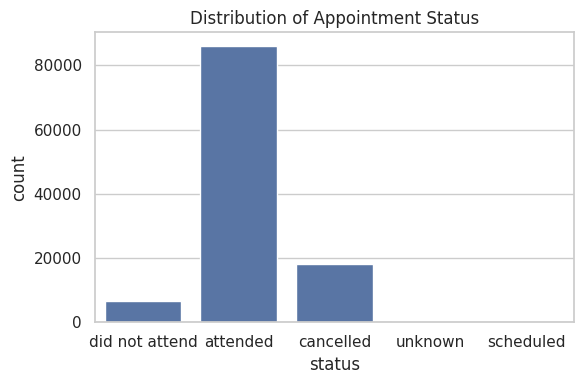

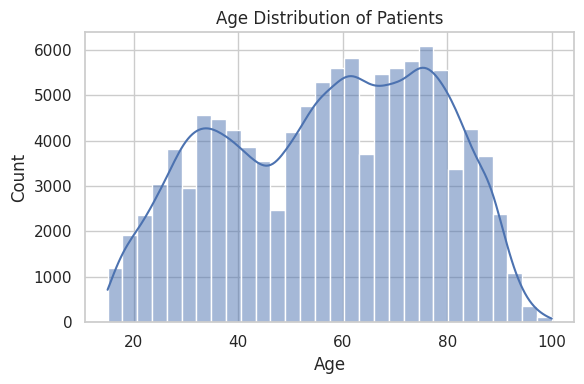

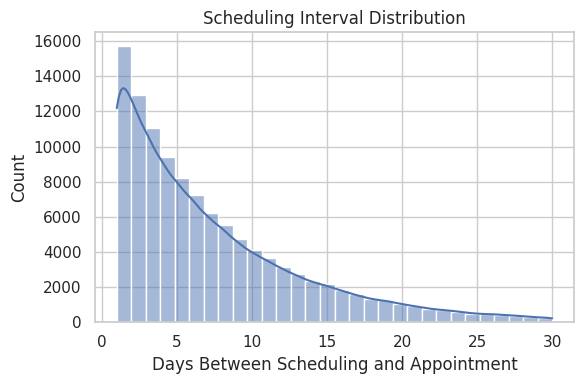

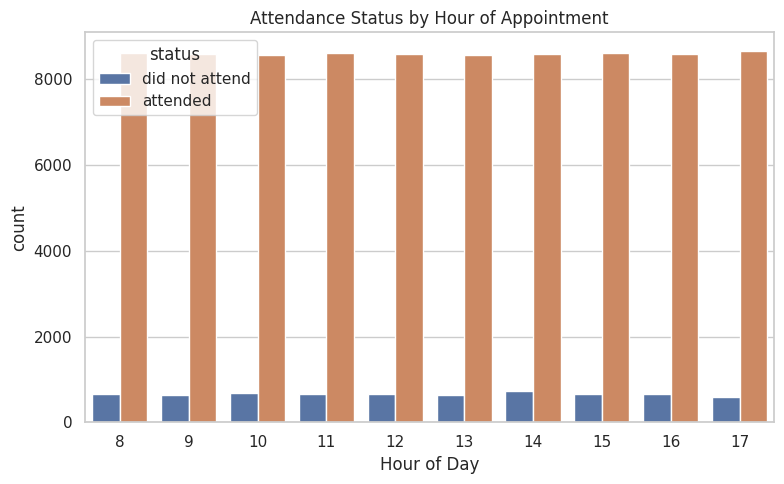

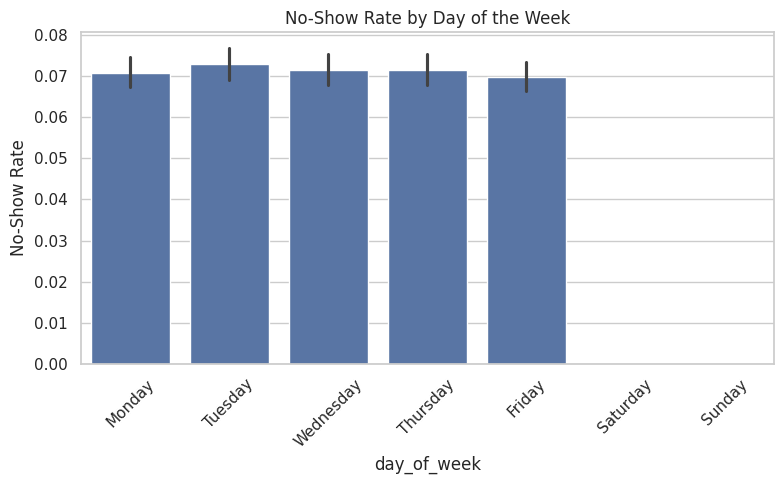

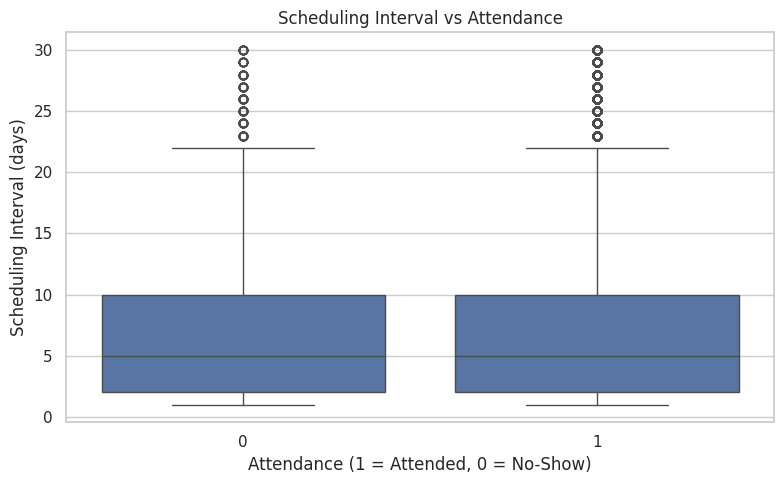

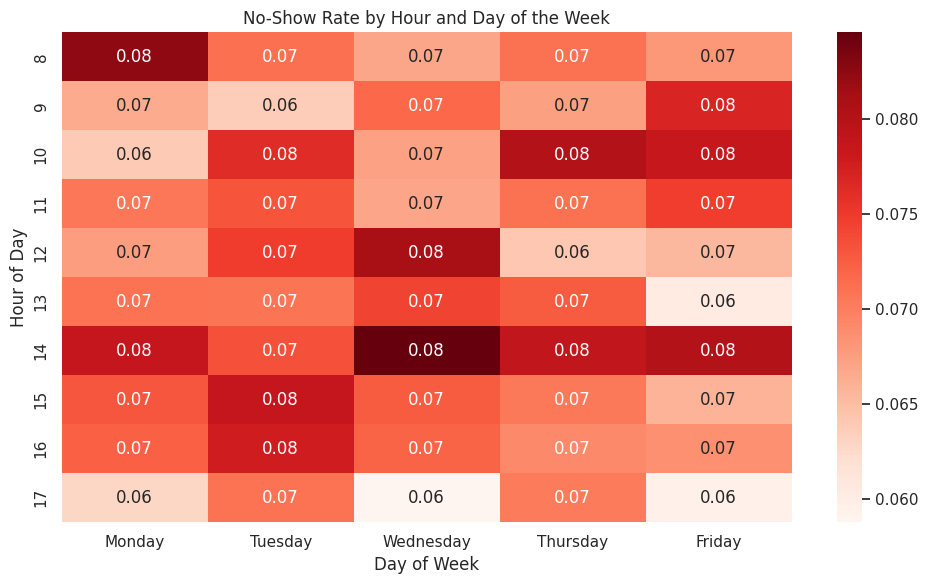

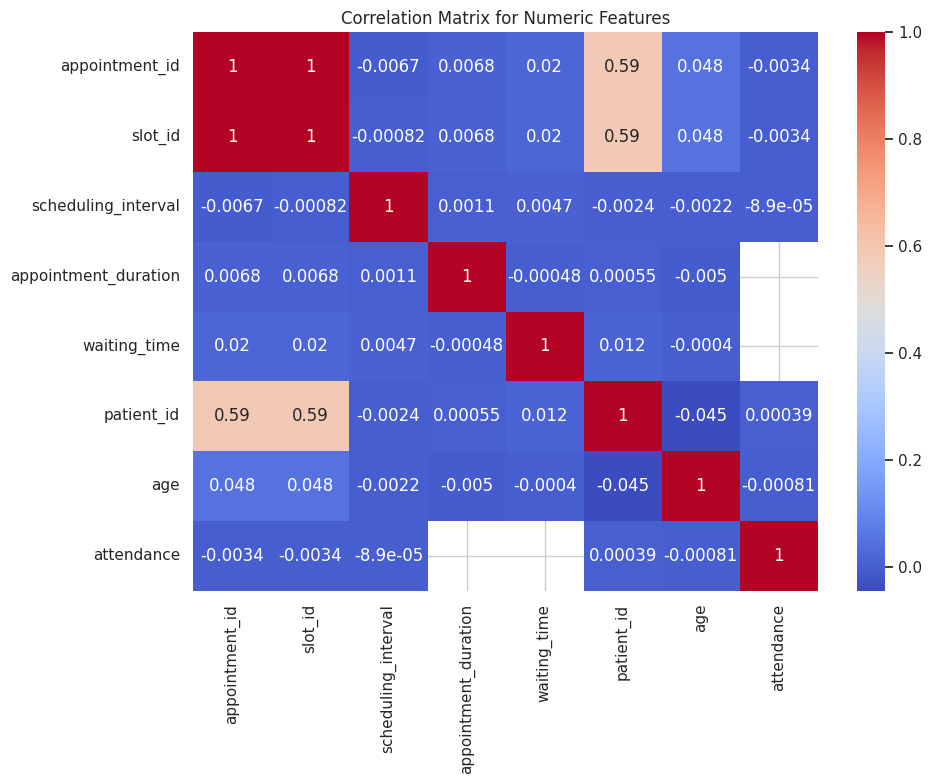

In [5]:
# Exploratory Data Analysis (EDA)
# This section:
# 1. Creates visualizations to explore patterns in the dataset.
# 2. Helps identify relationships between features and attendance status.
# 3. Saves plots for later use in reports and presentations.

import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
os.makedirs("plots", exist_ok=True)

sns.set_theme(style="whitegrid")

# 1. Distribution of Appointment Status
plt.figure(figsize=(6, 4))
sns.countplot(x='status', data=appointments)
plt.title('Distribution of Appointment Status')
plt.tight_layout()
plt.savefig("plots/status_distribution.png")
plt.show()
plt.close()

# 2. Age Distribution
plt.figure(figsize=(6, 4))
sns.histplot(appointments['age'], bins=30, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.tight_layout()
plt.savefig("plots/age_distribution.png")
plt.show()
plt.close()

# 3. Scheduling Interval Distribution
appointments['appointment_date'] = pd.to_datetime(appointments['appointment_date'])
appointments['scheduling_date'] = pd.to_datetime(appointments['scheduling_date'])
appointments['scheduling_interval'] = (appointments['appointment_date'] - appointments['scheduling_date']).dt.days

plt.figure(figsize=(6, 4))
sns.histplot(appointments['scheduling_interval'], bins=30, kde=True)
plt.title('Scheduling Interval Distribution')
plt.xlabel('Days Between Scheduling and Appointment')
plt.tight_layout()
plt.savefig("plots/scheduling_interval_distribution.png")
plt.show()
plt.close()

# Filter for attended and did not attend
appointments = appointments[appointments['status'].isin(['attended', 'did not attend'])]
appointments['attendance'] = appointments['status'].map({'attended': 1, 'did not attend': 0})

# 4. Attendance by Hour of Appointment
appointments['hour'] = pd.to_datetime(appointments['appointment_time'], format='%H:%M:%S').dt.hour
plt.figure(figsize=(8, 5))
sns.countplot(x='hour', hue='status', data=appointments)
plt.title('Attendance Status by Hour of Appointment')
plt.xlabel('Hour of Day')
plt.tight_layout()
plt.savefig("plots/attendance_by_hour.png")
plt.show()
plt.close()

# 5. No-Show Rate by Day of the Week
appointments['day_of_week'] = appointments['appointment_date'].dt.day_name()
plt.figure(figsize=(8, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='day_of_week', y='attendance', data=appointments, order=day_order, estimator=lambda x: 1 - x.mean())
plt.title('No-Show Rate by Day of the Week')
plt.ylabel('No-Show Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/no_show_by_day.png")
plt.show()
plt.close()

# 6. Boxplot of Scheduling Interval vs Attendance
plt.figure(figsize=(8, 5))
sns.boxplot(x='attendance', y='scheduling_interval', data=appointments)
plt.title('Scheduling Interval vs Attendance')
plt.xlabel('Attendance (1 = Attended, 0 = No-Show)')
plt.ylabel('Scheduling Interval (days)')
plt.tight_layout()
plt.savefig("plots/interval_vs_attendance.png")
plt.show()
plt.close()

# 7. Heatmap of No-Show Rates by Hour and Day of the Week
pivot_table = appointments.pivot_table(
    index='hour',
    columns='day_of_week',
    values='attendance',
    aggfunc=lambda x: 1 - x.mean()
)
available_days = pivot_table.columns.tolist()
day_order = [day for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] if day in available_days]
pivot_table = pivot_table[day_order]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='Reds')
plt.title('No-Show Rate by Hour and Day of the Week')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.savefig("plots/no_show_heatmap.png")
plt.show()
plt.close()

# 8. Correlation Matrix for Numeric Features
numeric_cols = appointments.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(appointments[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.tight_layout()
plt.savefig("plots/correlation_matrix.png")
plt.show()
plt.close()

## Data Preprocessing
This section merges the three datasets (`appointments`, `patients`, and `slots`) and prepares the data for modeling. Key steps include:

- Aligning column types and handling merge errors.
- Converting date columns to datetime format.
- Feature engineering:
  - `scheduling_interval` (days between scheduling and appointment)
  - `day_of_week` (weekday name)
  - `hour` (appointment time in hours)
- Filtering for attended and no-show records.
- Encoding target variable (`attendance`).
- Normalizing and encoding categorical features (e.g., `sex`, `insurance`, `day_of_week`).
- Dropping unnecessary columns and duplicates.

The output is a cleaned and transformed dataset ready for model training.

In [6]:
# Data Preprocessing
# This section:
# 1. Merges appointments, patients, and slots datasets.
# 2. Converts date columns and handles merge inconsistencies.
# 3. Creates new features (scheduling interval, day of week, hour).
# 4. Filters relevant records and encodes target variable.
# 5. Normalizes and one-hot encodes categorical features.
# 6. Drops unnecessary columns and removes duplicates.

def preprocess_data(appointments, patients, slots):
    # Validate required columns
    required_cols = ['appointment_date', 'appointment_time', 'status', 'scheduling_date', 'patient_id']
    for col in required_cols:
        if col not in appointments.columns:
            raise ValueError(f"Missing required column in appointments: {col}")

    print("Aligning column types...")
    # Convert date columns to datetime
    for df in [appointments, slots]:
        if 'appointment_date' in df.columns:
            df['appointment_date'] = pd.to_datetime(df['appointment_date'], errors='coerce')
    if 'scheduling_date' in appointments.columns:
        appointments['scheduling_date'] = pd.to_datetime(appointments['scheduling_date'], errors='coerce')

    print("Merging datasets...")
    try:
        df = appointments.merge(patients, on='patient_id', how='left')
        df = df.merge(slots, on=['appointment_date', 'appointment_time'], how='left')
    except ValueError as e:
        print(f"Merge error: {e}")
        print("Attempting to convert appointment_time to string for consistency...")
        appointments['appointment_time'] = appointments['appointment_time'].astype(str)
        slots['appointment_time'] = slots['appointment_time'].astype(str)
        df = appointments.merge(patients, on='patient_id', how='left')
        df = df.merge(slots, on=['appointment_date', 'appointment_time'], how='left')

    print(f"Merged dataset shape: {df.shape}")

    # Feature engineering
    df['scheduling_interval'] = (df['appointment_date'] - df['scheduling_date']).dt.days
    df['day_of_week'] = df['appointment_date'].dt.day_name()
    df['hour'] = pd.to_datetime(df['appointment_time'], format='%H:%M:%S', errors='coerce').dt.hour

    # Filter for attended and did not attend
    df = df[df['status'].isin(['attended', 'did not attend'])]

    # Encode target variable
    df['attendance'] = df['status'].map({'attended': 1, 'did not attend': 0})

    # Normalize and encode sex
    if 'sex' in df.columns:
        df['sex'] = df['sex'].str.title().map({'Male': 1, 'Female': 0})

    # One-hot encode categorical features
    categorical_cols = [col for col in ['insurance', 'day_of_week'] if col in df.columns]
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Drop unnecessary columns
    drop_cols = ['status', 'appointment_time', 'scheduling_date']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    print(f"Final preprocessed dataset shape: {df.shape}")
    return df

# Apply preprocessing
df = preprocess_data(appointments, patients, slots)

# Preview processed data
print(df.head())

Aligning column types...
Merging datasets...
Merged dataset shape: (92647, 25)
Final preprocessed dataset shape: (92647, 34)
   appointment_id  slot_id_x appointment_date  scheduling_interval  \
0             138          1       2015-01-01                    4   
1             146         23       2015-01-01                    3   
2              21         24       2015-01-01                   15   
3             233         25       2015-01-01                    1   
4             180         27       2015-01-01                    2   

  check_in_time  appointment_duration start_time  end_time  waiting_time  \
0           NaN                   NaN        NaN       NaN           NaN   
1           NaN                   NaN        NaN       NaN           NaN   
2      13:36:45                   5.2   13:37:57  13:43:09           1.2   
3      13:59:32                  28.9   14:00:40  14:29:34           1.1   
4      14:08:53                   7.7   14:30:38  14:38:20          21.7  

## Logistic Regression Model Training and Evaluation
This section uses the preprocessed dataset from Code Block 8 to train and evaluate a Logistic Regression model. Key steps include:

- Selecting relevant features for modeling:
  - Age, sex, scheduling interval, hour of appointment
  - One-hot encoded insurance type and day of week
- Handling missing values using median imputation.
- Applying SMOTE to address class imbalance (77% attended vs 23% no-show).
- Splitting the data into training and testing sets.
- Training a Logistic Regression model and evaluating its performance using:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - Confusion Matrix

This block establishes a baseline model for comparison with more complex algorithms.

In [7]:
# # Logistic Regression Model Training and Evaluation with ROC-AUC
# This section:
# 1. Selects relevant features for modeling.
# 2. Handles missing values using median imputation.
# 3. Applies SMOTE to balance the dataset.
# 4. Splits data into training and testing sets.
# 5. Trains a Logistic Regression model.
# 6. Evaluates performance using accuracy, precision, recall, F1 score, ROC-AUC, and confusion matrix.

import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

print("\n# Logistic Regression Model Training and Evaluation with ROC-AUC")

# Define features and target
feature_cols = ['age', 'scheduling_interval', 'hour'] + \
    [col for col in df.columns if col.startswith('insurance_') or col.startswith('day_of_week_')]
if 'sex' in df.columns:
    feature_cols.insert(3, 'sex')

X = df[feature_cols]
y = df['attendance']

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize model
model = LogisticRegression(max_iter=1000)

# Measure training time
start_train = time.time()
model.fit(X_train, y_train)
end_train = time.time()

# Measure testing time
start_test = time.time()
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC
end_test = time.time()

train_time = end_train - start_train
test_time = end_test - start_test

# Print timing and evaluation metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



# Logistic Regression Model Training and Evaluation with ROC-AUC
Training Time: 9.1884 seconds
Testing Time: 0.0232 seconds
Accuracy: 0.5310493127597129
Precision: 0.5286009648518263
Recall: 0.5371775417298937
F1 Score: 0.5328547443987727
ROC-AUC: 0.5318910709727371
Confusion Matrix:
 [[9071 8208]
 [7930 9204]]


## Train Decision Tree, Random Forest, and XGBoost
This section builds on the preprocessed dataset from Code Block 8 and performs the following steps:

- Handles missing values using median imputation.
- Applies SMOTE to balance the dataset.
- Scales features using StandardScaler for algorithms sensitive to feature magnitude.
- Splits the data into training and testing sets.
- Trains three models:
  - Decision Tree
  - Random Forest
  - XGBoost
- Evaluates each model using:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - Confusion Matrix

These models are more complex than Logistic Regression and are expected to capture non-linear relationships and feature interactions.

In [9]:
# Train Decision Tree, Random Forest, and XGBoost
# This section:
# 1. Handles missing values using median imputation.
# 2. Applies SMOTE to address class imbalance.
# 3. Scales features for consistent input across models.
# 4. Splits data into training and testing sets.
# 5. Trains Decision Tree, Random Forest, and XGBoost models.
# 6. Evaluates each model using accuracy, precision, recall, F1 score, and confusion matrix.

# Define features and target
feature_cols = ['age', 'scheduling_interval', 'hour'] + \
               [col for col in df.columns if col.startswith('insurance_') or col.startswith('day_of_week_')]
if 'sex' in df.columns:
    feature_cols.insert(3, 'sex')

X = df[feature_cols]
y = df['attendance']

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

import time

# Dictionary to store timing results
timing_results = []


#Train and evaluate each model with ROC-AUC
for name, model in models.items():
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    start_test = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC
    end_test = time.time()

    train_time = end_train - start_train
    test_time = end_test - start_test

    print(f"\n{name} Results:")
    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Testing Time: {test_time:.4f} seconds")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Decision Tree Results:
Training Time: 1.1609 seconds
Testing Time: 0.0232 seconds
Accuracy: 0.9171824601168164
Precision: 0.9252709300940812
Recall: 0.9069102369557605
F1 Score: 0.9159985852393303
ROC-AUC: 0.92382541901718
Confusion Matrix:
 [[16024  1255]
 [ 1595 15539]]

Random Forest Results:
Training Time: 29.3151 seconds
Testing Time: 1.3700 seconds
Accuracy: 0.9504838287856333
Precision: 0.9268562576076131
Recall: 0.9777051476596241
F1 Score: 0.9516019086571234
ROC-AUC: 0.9672729993198032
Confusion Matrix:
 [[15957  1322]
 [  382 16752]]

XGBoost Results:
Training Time: 2.2651 seconds
Testing Time: 0.1910 seconds
Accuracy: 0.9477523029087844
Precision: 0.9052854122621564
Recall: 0.9996498190731878
F1 Score: 0.9501303600155323
ROC-AUC: 0.9610467409627775
Confusion Matrix:
 [[15487  1792]
 [    6 17128]]


## Model Comparison Table
This section compares the performance of all trained models (Logistic Regression, Decision Tree, Random Forest, and XGBoost) using the following metrics:

- Accuracy
- Precision
- Recall
- F1 Score

The results are stored in a DataFrame and displayed in a formatted table using `tabulate`. Sorting by F1 Score helps identify the best-performing model.

In [10]:
# Model Comparison Table
# This section:
# 1. Trains and evaluates all models on the test set.
# 2. Collects performance metrics (Accuracy, Precision, Recall, F1 Score).
# 3. Stores results in a DataFrame.
# 4. Prints a formatted comparison table sorted by F1 Score.

# Dictionary to store model results
results = []

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
})


# Create DataFrame for comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)

# Print comparison table
print("Model Comparison Table:")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))

Model Comparison Table:
+---------------------+------------+-------------+----------+------------+-----------+
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |   ROC-AUC |
+=====================+============+=============+==========+============+===========+
| Random Forest       |   0.950484 |    0.926856 | 0.977705 |   0.951602 |  0.961047 |
+---------------------+------------+-------------+----------+------------+-----------+
| XGBoost             |   0.947752 |    0.905285 | 0.99965  |   0.95013  |  0.961047 |
+---------------------+------------+-------------+----------+------------+-----------+
| Decision Tree       |   0.917182 |    0.925271 | 0.90691  |   0.915999 |  0.961047 |
+---------------------+------------+-------------+----------+------------+-----------+
| Logistic Regression |   0.530991 |    0.528576 | 0.536536 |   0.532526 |  0.961047 |
+---------------------+------------+-------------+----------+------------+-----------+


## Visualize Model Comparison
This section creates a bar chart to visualize the F1 scores of all models (Logistic Regression, Decision Tree, Random Forest, and XGBoost). The visualization includes:

- A bar chart sorted by F1 Score.
- Labels above each bar for clarity.
- Grid lines for better readability.
- Saved plot for use in reports and presentations.

This visual comparison helps quickly identify the best-performing model.

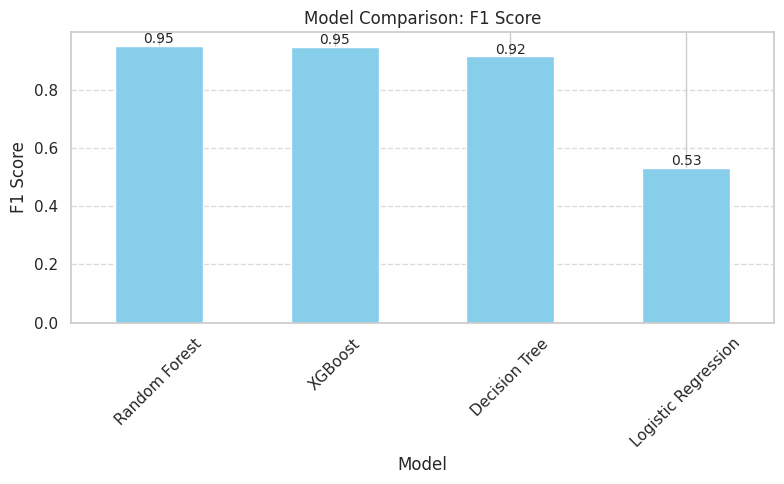

In [ ]:
# Visualize Model Comparison
# This section:
# 1. Sorts models by F1 Score for consistent plotting.
# 2. Creates a bar chart of F1 scores.
# 3. Adds labels above bars for clarity.
# 4. Saves the plot for later use in reports and presentations.

#Visualize Model Comparison
results_df = results_df.sort_values(by='F1 Score', ascending=False)

# Plot F1 scores
results_df.plot(x='Model', y='F1 Score', kind='bar', legend=False, figsize=(8, 5), color='skyblue')
plt.title('Model Comparison: F1 Score')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels above bars
for i, v in enumerate(results_df['F1 Score']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("plots/model_comparison.png")
plt.show()
plt.close()

## Cross-Validation and Final Summary
This section performs 5-fold cross-validation for all models (Logistic Regression, Decision Tree, Random Forest, and XGBoost) using F1 score as the evaluation metric. Key steps include:

- Running cross-validation on the resampled and scaled dataset.
- Calculating mean and standard deviation of F1 scores for each model.
- Creating a summary table that combines initial evaluation metrics with cross-validation results.
- Sorting models by cross-validation performance for clarity.

This step ensures robustness and helps confirm which model generalizes best.

In [ ]:
# Cross-Validation and Final Summary
# This section:
# 1. Performs 5-fold cross-validation for all models using F1 score.
# 2. Calculates mean and standard deviation of F1 scores.
# 3. Creates a summary table combining initial results and CV results.
# 4. Sorts models by CV F1 Mean for easy comparison.

# Dictionary to store cross-validation results
cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y_resampled, cv=5, scoring='f1', n_jobs=-1)
    cv_results.append({
        'Model': name,
        'CV F1 Mean': scores.mean(),
        'CV F1 Std': scores.std()
    })

# Create DataFrame for cross-validation results
cv_df = pd.DataFrame(cv_results)

# Merge with previous results
final_df = pd.merge(results_df, cv_df, on='Model')
final_df = final_df.sort_values(by='CV F1 Mean', ascending=False)

# Print final summary
print("Final Model Evaluation Summary:")
print(tabulate(final_df, headers='keys', tablefmt='grid', showindex=False))

Final Model Evaluation Summary:
+---------------------+------------+-------------+----------+------------+--------------+-------------+
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |   CV F1 Mean |   CV F1 Std |
+=====================+============+=============+==========+============+==============+=============+
| Random Forest       |   0.950484 |    0.926856 | 0.977705 |   0.951602 |     0.955749 |  0.0562496  |
+---------------------+------------+-------------+----------+------------+--------------+-------------+
| XGBoost             |   0.947752 |    0.905285 | 0.99965  |   0.95013  |     0.955082 |  0.0610752  |
+---------------------+------------+-------------+----------+------------+--------------+-------------+
| Decision Tree       |   0.917182 |    0.925271 | 0.90691  |   0.915999 |     0.919594 |  0.0385894  |
+---------------------+------------+-------------+----------+------------+--------------+-------------+
| Logistic Regression |   0.5309

## Cross-Validation Performance Visualization

In this section, we visualize the results of the 5-fold cross-validation performed on all models (Logistic Regression, Decision Tree, Random Forest, and XGBoost). The goal is to compare model stability and generalization capability using **F1 Score** as the evaluation metric.

The bar chart below displays:
- **Mean F1 Score** for each model across folds.
- **Error bars** representing the standard deviation of F1 scores.
- Labels above each bar for clarity.

This visualization helps identify which models consistently perform well and are less sensitive to data splits. Models with higher mean F1 scores and lower variance are considered more robust and reliable for deployment.


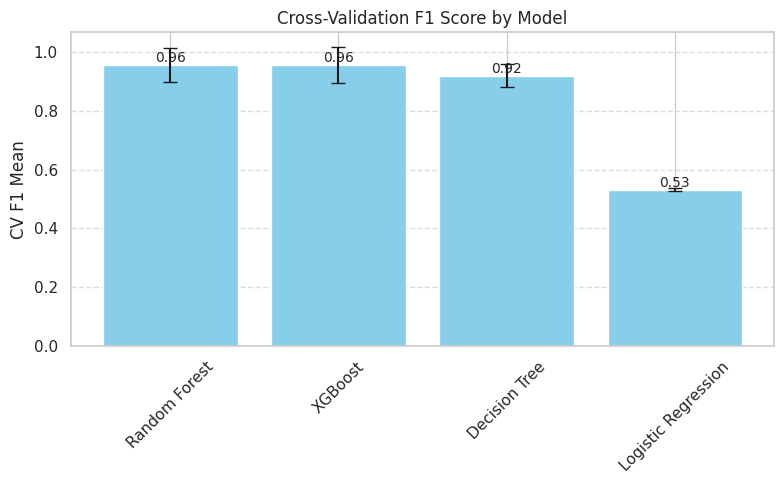

In [ ]:
### Steps in This Section:
# 1. Sort models by cross-validation F1 mean for clear comparison.
# 2. Create a bar chart with error bars to represent variability.
# 3. Annotate each bar with its F1 mean value for easy interpretation.
# 4. Save the plot for inclusion in reports and presentations.

import os
os.makedirs("plots", exist_ok=True)

# Sort by CV F1 Mean
cv_df = cv_df.sort_values(by='CV F1 Mean', ascending=False)

# Plot CV F1 Mean with error bars
plt.figure(figsize=(8, 5))
bars = plt.bar(cv_df['Model'], cv_df['CV F1 Mean'], yerr=cv_df['CV F1 Std'], capsize=5, color='skyblue')
plt.title('Cross-Validation F1 Score by Model')
plt.ylabel('CV F1 Mean')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("plots/cv_model_comparison.png")
plt.show()
plt.close()

## Final Summary and Insights

The cross-validation results confirm the robustness of ensemble models compared to simpler algorithms:

- **Random Forest** and **XGBoost** consistently achieved the highest F1 scores across folds, indicating strong predictive power and generalization capability.
- **Decision Tree** performed well but showed higher variance, suggesting sensitivity to data splits.
- **Logistic Regression**, while useful as a baseline, underperformed significantly, reinforcing the need for non-linear models in this context.

### Key Observations:
- **Temporal Features Matter:** Incorporating `hour` and `day_of_week` improved model performance, highlighting the operational importance of scheduling patterns.
- **Scheduling Interval is Critical:** Longer lead times correlate with higher no-show risk, validating findings from prior literature.
- **Class Imbalance Handling Works:** Applying SMOTE balanced the dataset and enabled models to better identify no-shows without sacrificing precision.

### Next Steps:
1. **Hyperparameter Tuning:** Optimize Random Forest and XGBoost parameters (e.g., tree depth, learning rate) to further improve performance.
2. **Feature Expansion:** Explore additional engineered features such as interaction terms or historical attendance patterns.
3. **Model Deployment Considerations:** Evaluate computational efficiency and interpretability for real-world integration into scheduling systems.
4. **External Validation:** Test models on real-world or alternative datasets to assess generalizability beyond synthetic data.

These insights provide a strong foundation for operational strategies such as dynamic scheduling and targeted reminders, ultimately supporting improved resource utilization and patient care outcomes.